# Genetic optimization of rbf-kernel SVM classifier for the SDSS data

## Load data

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_test = std_scaler.fit_transform(X_test.astype(np.float64))
X_train = std_scaler.fit_transform(X_train.astype(np.float64))

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


## Optimize

In [2]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV
import random
from sklearn.model_selection import StratifiedKFold

paramgrid = {"kernel": ["rbf"],
             "C": np.logspace(-9, 5, num=20, base=10),
             "gamma": np.logspace(-9, 5, num=20, base=10),
             "degree": range(3,10),
             "coef0": np.logspace(-9, 5, num=20, base=10),
             "shrinking": [True, False],
             "probability": [False, True],
             "tol": [0.001],
             "cache_size": [20, 50, 100, 200, 500, 1000],
             "class_weight": [None],
             "verbose": [False],
             "max_iter": [-1],
             "random_state": [42]
             }

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=SVC(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=5,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   tournament_size=3,
                                   generations_number=30,
                                   n_jobs=8,
                                   error_score=0.0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = cv.fit(X_train, y_train)

Types [1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1] and maxint [0, 19, 19, 6, 19, 1, 1, 0, 5, 0, 0, 0, 0] detected
[CV] kernel=rbf, C=18329.8071083243, gamma=2.976351441631319e-08, degree=5, coef0=1.623776739188721e-07, shrinking=False, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
--- Evolve in 1344000 possible combinations ---
[CV] kernel=rbf, C=3359.8182862837743, gamma=1e-09, degree=6, coef0=2.6366508987303556e-05, shrinking=False, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=18329.8071083243, gamma=112.88378916846884, degree=9, coef0=615.8482110660254, shrinking=False, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=4, coef0=615.8482110660254, shrinking=False, probability=True, tol=0.001, cache_size=200, class_we

[CV]  kernel=rbf, C=0.0007847599703514606, gamma=1.623776739188721e-07, degree=5, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=  11.4s
[CV] kernel=rbf, C=0.0007847599703514606, gamma=1.623776739188721e-07, degree=5, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.004281332398719387, gamma=8.858667904100833e-07, degree=4, coef0=5.455594781168515e-09, shrinking=False, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   2.1s
[CV] kernel=rbf, C=1e-09, gamma=3359.8182862837743, degree=9, coef0=5.455594781168515e-09, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] 

[CV]  kernel=rbf, C=2.6366508987303556e-05, gamma=18329.8071083243, degree=8, coef0=3.7926901907322383, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=  18.6s
[CV] kernel=rbf, C=2.6366508987303556e-05, gamma=18329.8071083243, degree=8, coef0=3.7926901907322383, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=112.88378916846884, degree=9, coef0=615.8482110660254, shrinking=False, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.6506666666666666, total=  13.2s
[CV] kernel=rbf, C=18329.8071083243, gamma=112.88378916846884, degree=9, coef0=615.8482110660254, shrinking=False, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel

[CV]  kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=4, coef0=615.8482110660254, shrinking=False, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=  35.3s
[CV] kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=4, coef0=615.8482110660254, shrinking=False, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=2.976351441631319e-08, gamma=20.6913808111479, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=   3.4s
[CV] kernel=rbf, C=2.976351441631319e-08, gamma=20.6913808111479, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf

[CV]  kernel=rbf, C=1.623776739188721e-07, gamma=0.6951927961775591, degree=7, coef0=0.1274274985703132, shrinking=False, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   2.6s
[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.023357214690901212, shrinking=False, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=3.7926901907322383, degree=7, coef0=1e-09, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9266177451634423, total=  10.7s
[CV] kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=9, coef0=1.623776739188721e-07, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kerne

[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.023357214690901212, shrinking=False, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9746497665110073, total=   4.9s
[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.023357214690901212, shrinking=False, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.6951927961775591, degree=5, coef0=1e-09, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9639759839893263, total=   1.0s
[CV] kernel=rbf, C=100000.0, gamma=0.6951927961775591, degree=5, coef0=1e-09, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=1.623776739188721e-07, g

[CV] kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=9, coef0=1.623776739188721e-07, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=4.832930238571752e-06, gamma=1.623776739188721e-07, degree=6, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   2.5s
[CV] kernel=rbf, C=0.6951927961775591, gamma=2.976351441631319e-08, degree=5, coef0=3359.8182862837743, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.004281332398719387, gamma=2.6366508987303556e-05, degree=4, coef0=0.1274274985703132, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total

[CV] kernel=rbf, C=0.0007847599703514606, gamma=112.88378916846884, degree=3, coef0=3.7926901907322383, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=8.858667904100833e-07, gamma=2.6366508987303556e-05, degree=4, coef0=3359.8182862837743, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=   9.9s
[CV] kernel=rbf, C=8.858667904100833e-07, gamma=2.6366508987303556e-05, degree=4, coef0=3359.8182862837743, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=18329.8071083243, degree=7, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=  28.7s
[CV] kerne

[CV] kernel=rbf, C=0.004281332398719387, gamma=2.6366508987303556e-05, degree=4, coef0=0.1274274985703132, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.0007847599703514606, degree=8, coef0=3359.8182862837743, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9533333333333334, total=   5.3s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.0007847599703514606, degree=8, coef0=3359.8182862837743, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=8.858667904100833e-07, gamma=2.6366508987303556e-05, degree=4, coef0=3359.8182862837743, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5, total=   9.2s
[CV] kernel=rbf

[CV] kernel=rbf, C=0.0001438449888287663, gamma=4.832930238571752e-06, degree=7, coef0=18329.8071083243, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=5.455594781168515e-09, gamma=0.023357214690901212, degree=4, coef0=0.023357214690901212, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   2.3s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.0001438449888287663, degree=9, coef0=0.6951927961775591, shrinking=False, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=9, coef0=1.623776739188721e-07, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5006666666666667, total=  26.6

[CV]  kernel=rbf, C=20.6913808111479, gamma=0.0001438449888287663, degree=9, coef0=0.6951927961775591, shrinking=False, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.8753333333333333, total=   6.6s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.0001438449888287663, degree=9, coef0=0.6951927961775591, shrinking=False, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.0007847599703514606, gamma=2.976351441631319e-08, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=   9.4s
[CV] kernel=rbf, C=0.0007847599703514606, gamma=2.976351441631319e-08, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 


[CV]  kernel=rbf, C=0.0007847599703514606, gamma=2.976351441631319e-08, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   8.6s
[CV] kernel=rbf, C=0.0007847599703514606, gamma=2.976351441631319e-08, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=1.623776739188721e-07, gamma=18329.8071083243, degree=8, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=   3.8s
[CV] kernel=rbf, C=1.623776739188721e-07, gamma=18329.8071083243, degree=8, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=4.83

[CV]  kernel=rbf, C=3.7926901907322383, gamma=8.858667904100833e-07, degree=8, coef0=0.6951927961775591, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   2.2s
[CV] kernel=rbf, C=3.7926901907322383, gamma=8.858667904100833e-07, degree=8, coef0=0.6951927961775591, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=9, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5010006671114076, total=   6.4s
[CV] kernel=rbf, C=0.1274274985703132, gamma=2.976351441631319e-08, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=4

[CV] kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=4, coef0=0.023357214690901212, shrinking=False, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=4, coef0=0.023357214690901212, shrinking=False, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9533333333333334, total=   1.0s
[CV]  kernel=rbf, C=3359.8182862837743, gamma=1e-09, degree=5, coef0=100000.0, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5, total=   9.0s
[CV] kernel=rbf, C=3359.8182862837743, gamma=1e-09, degree=5, coef0=100000.0, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=615.8482110660254, gamma=2.63665089873

[CV] kernel=rbf, C=615.8482110660254, gamma=1e-09, degree=8, coef0=0.6951927961775591, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=4.832930238571752e-06, gamma=615.8482110660254, degree=9, coef0=2.6366508987303556e-05, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=  11.2s
[CV] kernel=rbf, C=4.832930238571752e-06, gamma=615.8482110660254, degree=9, coef0=2.6366508987303556e-05, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=18329.8071083243, degree=9, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   9.9s
[CV]  kernel=rbf, C=615.

[CV] kernel=rbf, C=1.623776739188721e-07, gamma=0.1274274985703132, degree=9, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=20.6913808111479, degree=9, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.843437708194537, total=   4.0s
[CV] kernel=rbf, C=18329.8071083243, gamma=20.6913808111479, degree=9, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=2.6366508987303556e-05, gamma=0.6951927961775591, degree=5, coef0=3.7926901907322383, shrinking=False, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=   2.5s
[CV] kernel=rbf, C=2.6366508987303

[CV] kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=9, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=2.976351441631319e-08, gamma=0.004281332398719387, degree=8, coef0=3.7926901907322383, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=   9.9s
[CV] kernel=rbf, C=2.976351441631319e-08, gamma=0.004281332398719387, degree=8, coef0=3.7926901907322383, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=9, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5016655562958028, total=  

[CV] kernel=rbf, C=8.858667904100833e-07, gamma=1.623776739188721e-07, degree=7, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamma=1e-09, degree=7, coef0=0.6951927961775591, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   9.8s
[CV] kernel=rbf, C=615.8482110660254, gamma=1e-09, degree=7, coef0=0.6951927961775591, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=9, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5010006671114076, total=   5.6s
[CV] kernel=rbf, C=0.69519279617

[CV] kernel=rbf, C=20.6913808111479, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9686875416389074, total=   2.7s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9813457694870087, total=   1.9s
[CV] kernel=rb

[CV] kernel=rbf, C=615.8482110660254, gamma=1e-09, degree=8, coef0=0.6951927961775591, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.970647098065377, total=   3.0s
[CV] kernel=rbf, C=0.6951927961775591, gamma=0.004281332398719387, degree=7, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=5, coef0=0.1274274985703132, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9419613075383589, total=   3.3s
[CV] kernel=rbf, C

[CV]  kernel=rbf, C=3.7926901907322383, gamma=100000.0, degree=8, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5, total=  18.9s
[CV] kernel=rbf, C=3.7926901907322383, gamma=100000.0, degree=8, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=3359.8182862837743, degree=7, coef0=2.976351441631319e-08, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5006666666666667, total=  26.2s
[CV] kernel=rbf, C=3359.8182862837743, gamma=3359.8182862837743, degree=7, coef0=2.976351441631319e-08, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, 

[CV]  kernel=rbf, C=3359.8182862837743, gamma=3359.8182862837743, degree=7, coef0=2.976351441631319e-08, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=  25.6s
[CV] kernel=rbf, C=3359.8182862837743, gamma=3359.8182862837743, degree=7, coef0=2.976351441631319e-08, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0007847599703514606, degree=5, coef0=0.1274274985703132, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9919946631087392, total=  11.7s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0007847599703514606, degree=5, coef0=0.1274274985703132, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42

[CV]  kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=4, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9699799866577719, total=   0.6s
[CV]  kernel=rbf, C=3359.8182862837743, gamma=3359.8182862837743, degree=7, coef0=2.976351441631319e-08, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=  26.2s
[CV]  kernel=rbf, C=615.8482110660254, gamma=1e-09, degree=8, coef0=0.6951927961775591, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5, total=   7.5s
[CV] kernel=rbf, C=615.8482110660254, gamma=1e-09, degree=8, coef0=0.6951927961775591, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=r

[CV]  kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=3, coef0=615.8482110660254, shrinking=False, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=  17.2s
[CV]  kernel=rbf, C=3.7926901907322383, gamma=100000.0, degree=7, coef0=3.7926901907322383, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5, total= 1.0min
[CV] kernel=rbf, C=3.7926901907322383, gamma=100000.0, degree=7, coef0=3.7926901907322383, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3.7926901907322383, gamma=100000.0, degree=7, coef0=3.7926901907322383, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total= 1.0min
[CV] kernel=rbf, C=3.79

[CV]  kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=4, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9699799866577719, total=   0.7s
[CV] kernel=rbf, C=3359.8182862837743, gamma=3359.8182862837743, degree=7, coef0=5.455594781168515e-09, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9699799866577719, total=   0.9s
[CV] kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=9, coef0=4.832930238571752e-06, shrinking=False, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  

[CV] kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=9, coef0=4.832930238571752e-06, shrinking=False, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=3359.8182862837743, degree=9, coef0=0.004281332398719387, shrinking=False, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=  28.7s
[CV] kernel=rbf, C=0.6951927961775591, gamma=3359.8182862837743, degree=9, coef0=0.004281332398719387, shrinking=False, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=3.7926901907322383, degree=5, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9553333333333334, total=   8.8s
[CV] k

[CV]  kernel=rbf, C=0.6951927961775591, gamma=0.004281332398719387, degree=9, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.87, total=   1.8s
[CV] kernel=rbf, C=0.6951927961775591, gamma=0.004281332398719387, degree=9, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=0.1274274985703132, degree=7, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9653333333333334, total=   1.1s
[CV] kernel=rbf, C=0.6951927961775591, gamma=0.1274274985703132, degree=7, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]

[CV] kernel=rbf, C=615.8482110660254, gamma=1e-09, degree=8, coef0=0.6951927961775591, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9746497665110073, total=   3.4s
[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.0007847599703514606, degree=8, coef0=3359.8182862837743, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9447035309793471, total=   5.2s
[CV] kernel=rbf, C=20

[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=9, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.023357214690901212, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9686875416389074, total=   4.8s
[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.023357214690901212, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.0007847599703514606, degree=8, coef0=3359.8182862837743, shrinking=True, probability=True, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9466310873915944, total=   4.5s
[CV] kern

[CV] kernel=rbf, C=0.6951927961775591, gamma=3.7926901907322383, degree=7, coef0=1e-09, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=2.976351441631319e-08, gamma=615.8482110660254, degree=8, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=  17.8s
[CV] kernel=rbf, C=2.976351441631319e-08, gamma=615.8482110660254, degree=8, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=615.8482110660254, degree=9, coef0=5.455594781168515e-09, shrinking=False, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5123251165889408, total= 1.8min
[CV] kernel=rbf, C

[CV] kernel=rbf, C=2.976351441631319e-08, gamma=615.8482110660254, degree=8, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=112.88378916846884, degree=5, coef0=0.1274274985703132, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.6644429619746498, total=  30.6s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.0001438449888287663, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9686875416389074, total=   0.6s
[C

[CV] kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=4, coef0=0.1274274985703132, shrinking=False, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=9, coef0=1.623776739188721e-07, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5006666666666667, total=  26.3s
[CV] kernel=rbf, C=18329.8071083243, gamma=3359.8182862837743, degree=9, coef0=1.623776739188721e-07, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=4, coef0=0.1274274985703132, shrinking=False, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9486324216144096, total=   3.6s
[C

[CV] kernel=rbf, C=20.6913808111479, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=4, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
2  	29    	0.818685	0.500267	0.989333	0.202461
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9813457694870087, total=   0.7s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kern

[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=8, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9640239840106596, total=   2.6s
[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=8, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0001438449888287663, degree=5, coef0=0.6951927961775591, shrinking=False, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9419613075383589, total=   1.2s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.0007847599703514606, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42

[CV] kernel=rbf, C=112.88378916846884, gamma=2.6366508987303556e-05, degree=8, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=8, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.971314209472982, total=   3.4s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=4, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9766666666666667, total=   3.9s
[

[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=3.7926901907322383, degree=7, coef0=1e-09, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9247168554297135, total=  10.6s
[CV] kernel=rbf, C=0.6951927961775591, gamma=3.7926901907322383, degree=7, coef0=1e-09, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.970647098065377, total=   4.0s
[CV] kernel=rbf, C=112.88378916846884, ga

[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=9, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9753497668221186, total=   1.5s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=9, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=3, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3.7926901907322383, gamma=3.7926901907322383, degree=8, coef0=5.455594781168515e-09, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9606666666666667, total=  10.5s
[CV] kernel=rbf, C=3.79

[CV] kernel=rbf, C=0.004281332398719387, gamma=2.6366508987303556e-05, degree=5, coef0=0.023357214690901212, shrinking=False, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3.7926901907322383, gamma=3.7926901907322383, degree=8, coef0=5.455594781168515e-09, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9419613075383589, total=  10.8s
[CV] kernel=rbf, C=3.7926901907322383, gamma=3.7926901907322383, degree=8, coef0=5.455594781168515e-09, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.004281332398719387, gamma=2.6366508987303556e-05, degree=5, coef0=0.023357214690901212, shrinking=False, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, 

[CV] kernel=rbf, C=0.6951927961775591, gamma=0.004281332398719387, degree=5, coef0=5.455594781168515e-09, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=3, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5006666666666667, total=   5.7s
[CV] kernel=rbf, C=0.6951927961775591, gamma=615.8482110660254, degree=3, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9753168779186124, total=   3.4

[CV] kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=4, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=3.7926901907322383, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9766666666666667, total=   0.9s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=3.7926901907322383, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=4, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9699799866577719, total=   0.7s
[CV] k

[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.0001438449888287663, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.971314209472982, total=   0.9s
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=8, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9640239840106596, total=   3.3s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=8, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=

[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0007847599703514606, degree=7, coef0=0.0001438449888287663, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866577718478986, total=   9.6s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=4, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=4, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=20.6913808111479, gamma=20.6913808111479, degree=4, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=112.88378916846884, gamma=3359.81828

[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=4, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913333333333333, total=   0.8s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=20.6913808111479, gamma=0.004281332398719387, degree=4, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9746497665110073, total=   0.7s
[CV] kernel

[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=9, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.982, total=   0.7s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=9, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.004281332398719387, degree=5, coef0=0.0001438449888287663, shrinking=False, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9819879919946631, total=   1.1s
[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.1274274985703132, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, sco

[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9853431045969354, total=   1.7s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=7, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=3.7926901907322383, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9753168779186124, total=   0.8s
[CV] kernel=

[CV] kernel=rbf, C=615.8482110660254, gamma=0.0001438449888287663, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=20.6913808111479, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=8, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9640239840106596, total=   3.0s
[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=8, coef0=615.8482110660254, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamm

[CV]  kernel=rbf, C=20.6913808111479, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9466310873915944, total=   1.6s
[CV] kernel=rbf, C=20.6913808111479, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   0.7s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=r

[CV]  kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=5, coef0=0.0007847599703514606, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9533333333333334, total=   5.4s
[CV] kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=5, coef0=0.0007847599703514606, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893333333333333, total=   0.6s
[CV] kernel=rbf, C=615.8482110660254, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[C

[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=20.6913808111479, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.970647098065377, total=   2.6s
[CV] kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=8, coef0=0.1274274985703132, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=5, coef0=0.0007847599703514606, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9486324216144096, total=   5.2s
[CV] kernel=rbf, C=615.8482110660254, gamma=2.6366508987303556e-05, degree=5, coef0=0.0007847599703514606, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=4

[CV] kernel=rbf, C=20.6913808111479, gamma=20.6913808111479, degree=4, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=8, coef0=0.023357214690901212, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9640239840106596, total=   0.9s
[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=8, coef0=0.023357214690901212, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.023357214690901212, degree=9, coef0=0.6951927961775591, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.983344437041972, total=  12.6s
[C

[CV] kernel=rbf, C=112.88378916846884, gamma=3359.8182862837743, degree=8, coef0=20.6913808111479, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0007847599703514606, degree=5, coef0=0.0001438449888287663, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866577718478986, total=   4.0s
[CV]  kernel=rbf, C=112.88378916846884, gamma=2.6366508987303556e-05, degree=5, coef0=0.6951927961775591, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.8639092728485657, total=   4.5s
[CV] kernel=rbf, C=112.88378916846884, gamma=2.6366508987303556e-05, degree=5, coef0=0.6951927961775591, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=4

[CV]  kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.1274274985703132, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9686875416389074, total=   0.9s
[CV] kernel=rbf, C=3359.8182862837743, gamma=2.6366508987303556e-05, degree=5, coef0=0.1274274985703132, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=8, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9753497668221186, total=   0.6s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=8, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_st

[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.988674217188541, total=   0.7s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=3.7926901907322383, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9686875416389074, total=   0.7s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=3.7926901907322383, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] 

[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=8, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   1.6s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=8, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=3.7926901907322383, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.970647098065377, total=   0.7s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42

[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=5, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   0.6s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=5, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=0.6951927961775591, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9640239840106596, total=   0.9

[CV] kernel=rbf, C=615.8482110660254, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.99, total=   0.8s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=4, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9820119920053297, total=   9.0s
[CV] kernel=rbf, C=112.8837891

[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=4, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866666666666667, total=   0.7s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=8, coef0=0.004281332398719387, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9826551034022681, total=   1.2s
[CV] k

[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.004281332398719387, degree=4, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9886591060707138, total=   0.8s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.004281332398719387, degree=4, coef0=1e-09, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.023357214690901212, degree=9, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9879919946631087, total=   0.6s
[CV]  kernel=rbf, C=112.883789168

[CV]  kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=4, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866666666666667, total=   5.9s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=4, coef0=3.7926901907322383, shrinking=False, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma

[CV] kernel=rbf, C=3359.8182862837743, gamma=0.023357214690901212, degree=4, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
5  	28    	0.965259	0.500533	0.9904  	0.0900236
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.988674217188541, total=   

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9886591060707138, total=   0.5s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=0.6951927961775591, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   3.3s
[CV] kernel=rbf, 

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.99, total=   0.8s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=False, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.988674217188541, total=   6.3s
[CV] kernel=rbf, C=3359.8182862837743, gamm

[CV] kernel=rbf, C=615.8482110660254, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamma=0.004281332398719387, degree=9, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893333333333333, total=   2.0s
[CV] kernel=rbf, C=615.8482110660254, gamma=0.004281332398719387, degree=9, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.023357214690901212, degree=5, coef0=5.455594781168515e-09, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   0.9s
[CV] kernel=

[CV] kernel=rbf, C=18329.8071083243, gamma=0.0001438449888287663, degree=4, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   2.5s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.023357214690901212, degree=5, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=615.8482110660254, gamma=0.004281332398719387, degree=9, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866577718478986, total=   1.9s
[CV

[CV]  kernel=rbf, C=18329.8071083243, gamma=0.0001438449888287663, degree=4, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913275517011341, total=   0.6s
[CV] kernel=rbf, C=18329.8071083243, gamma=0.0001438449888287663, degree=4, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=0.023357214690901212, degree=4, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9840106595602931, total=   1.9s
[CV] kernel=rbf, C=18329.8071083243, gamma=0.023357214690901212, degree=4, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_stat

[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9853431045969354, total=   1.0s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9853431045969354, total=   1.0s
[CV] kernel=rbf, C=100000.0, gamma

[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=3.7926901907322383, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   1.2s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.0007847599703514606, degree=8, coef0=3.7926901907322383, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   1.3s
[CV] kernel=rbf, C=

[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=3.7926901907322383, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=3.7926901907322383, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   1.8s
[CV] kernel=rbf, C=112.88378916846884, gamma=0.1274274985703132, degree=8, coef0=3.7926901907322383, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=4, coef0=0.1274274985703132, shrinking=False, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9886591060707138, total=   5.9s
[CV]  k

[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913333333333333, total=   0.6s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.004281332398719387, d

[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893404397068621, total=   1.0s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   1.4s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0

[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893404397068621, total=   1.0s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   1.1s
[CV] kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=r

[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   1.4s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   4.9s
[CV] kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   3.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.994, total=   4.8s
[CV] kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=10000

[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893404397068621, total=   0.7s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9853431045969354, total=   0.8s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, 

[CV]  kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=8, coef0=5.455594781168515e-09, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   0.4s
[CV] kernel=rbf, C=3359.8182862837743, gamma=0.0001438449888287663, degree=8, coef0=5.455594781168515e-09, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9853431045969354, total=   0.7s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  

[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   1.4s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=  10.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, 

[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893404397068621, total=   1.0s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893404397068621, total=   0.9s
[CV] kernel=rbf, C=100000.0

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=100000.0, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   6.8s
[CV] kernel=rbf, C=100000.0, gamma=100000.0, degree=5, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   9.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, d

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.1274274985703132, shrinking=False, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=5, coef0=0.0007847599703514606, shrinking=True, 

[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=4, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   1.9s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=4, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=1e-09, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   2.3s
[CV] kernel=rbf, C=100000.0, gamma=0.0001438449888287663, degree=8, coef0=1e-09, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, 

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   5.5s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.3s
[CV] kernel=rbf, C=18329.80710

[CV] kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=  20.5s
[CV] kernel=rbf, C=10

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   4.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   1.9s
[CV] kernel=rbf, C=100

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   3.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   4.7s
[CV] kernel=rbf, C=100000.0, gamma=0.00428133

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.0s
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.3s
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.1274274985703132, shrinking=False, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, tota

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=4.832930238571752e-06, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shri

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   3.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=4.832930238571752e-06, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   2.7s
[CV] kernel=rbf, C=18329.8071083243, g

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=20.6913808111479, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=18329.8071083243, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   1.8s
[CV]  kernel=rbf, C=100000.0

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=  17.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   5.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, ga

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   5.9s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=  18.2s
[CV] kernel=rbf, C=100000.0, gamma

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=5, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   5.7s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=5, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=18329.8071083243, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003331112591606, total=  28.5s
[CV] kernel=rbf, C=100000.0, gamma=18329.8071083243, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   4.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.5s
[CV] kernel=rbf, C=100000.0, gamma=0.0042

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  13.8s
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  13.4s
[CV]  kernel=rbf, C=100000.0, gamma=18329.8071083243, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5, total=  21.3s
[CV] kernel=rbf, C=100000.0, gamma=18329.8071083243, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   5.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   2.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   5.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   5.4s
[CV] kernel=rbf, C=100000.0, gamm

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   4.7s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.1s
[CV] kernel=rbf, C=100000.0, g

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0,

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.5s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=1000

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   3.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.5s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=1000

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=  17.5s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=  17.7s
[CV] kernel=rbf, C=100000.0, gamma=0.00428133

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=6, coef0=3359.8182862837743, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   3.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=6, coef0=3359.8182862837743, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=50, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.5s
[CV] kernel=rbf, C=100000.0, gamma=0.0042813323987

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  14.3s
[CV]  kernel=rbf, C=100000.0, gamma=0.0

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   3.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   3.3s
[CV]  kernel=rbf, C=100000.0,

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   2.4s
[CV]  kernel=rbf, C=100000.0, g

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=5.455594781168515e-09, degree=7, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.7878585723815877, total=   1.3s
[CV] kernel=rbf, C=100000.0, gamma=5.455594781168515e-09, degree=7, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   2.6s
[CV] kernel=rbf, C=10000

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   4.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamm

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=  14.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamma=0.0042813323

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   3.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=  11.9s
[CV] kernel=rbf, C=100000.0, gamma=

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   1.6s
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=  11.0s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, ga

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
11 	28    	0.976499	0.500267	0.9904  	0.0738331  
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degr

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=112.88378916846884, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   2.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=112.88378916846884, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   1.7s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0042813323987

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   1.8s
[CV] kernel=rbf, C=4.832930238571752e-06, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=6, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   2.1s
[CV] kernel=rbf, C=

[CV] kernel=rbf, C=0.023357214690901212, gamma=0.004281332398719387, degree=8, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   1.9s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   1.6s
[CV] kernel=rbf, C=1000

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=6, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   3.0s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   1.6s
[CV] kernel=rbf, C=4.83293023857175

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=4.832930238571752e-06, gamma=0.004281332398719387, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   1.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   2.9s
[CV] kernel=rbf, C=1

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   2.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   2.6s
[CV] kernel=rbf, C=100000.0, g

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   2.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   2.0s
[CV] kernel=rbf, C=100000.0, ga

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   2.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=8.858667904100833e-07, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   9.8s
[CV] kernel=rbf, C=100000.0, ga

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   8.1s
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   1.5s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.00428

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
12 	34    	0.952861	0.500267	0.9904  	0.120684   
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   2.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.99133910726182

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   2.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   3.5s
[CV] kernel=rbf, C=100000.0, gam

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=0.6951927961775591, gamma=0.004281332398719387, degree=4, coef0=8.858667904100833e-07, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.8540972684876749, total=   3.5s
[CV] kernel=rbf, C=0.6951927961775591, gamma=0.004281332398719387, degree=4, coef0=8.858667904100833e-07, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   2.7s
[CV] kernel=rbf

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=  12.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=  15.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=  53.9s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.5s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, 

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=  16.8s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0042813

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.5s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=True, probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  12.7s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0,

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   4.9s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   2.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, 

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=  48.7s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=False, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   4.0s
[CV] kernel=rbf, C=100000.0, 

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   2.9s
[CV] kernel=rbf, C=100000.0, gamma=0.004281

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.5s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.8s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, de

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   4.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   3.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   2.8s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=  17.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, ga

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   3.0s
[CV] kernel=rbf, C=100000.0, gamma=6

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  12.6s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=   2.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gam

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   4.8s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=7, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   2.8s
[CV] kernel=rbf, C=100000.0, gamma=0.00

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  12.4s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   3.8s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.0042813323

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=112.88378916846884, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  11.4s
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  12.8s
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=  13.7s
[CV] kernel=r

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   4.0s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   1.7s
[CV] kernel=rbf, C=100000.0

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   5.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.023357214690901212, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   5.0s
[CV] kernel=rbf, C=100000.0, gamm

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.9s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.0001438449888287663, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=   3.0s
[CV] kernel=rbf, C=100000.0, g

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0001438449888287663, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=9, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   2.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=9, coef0=0.0007847599703514606, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   3.2s
[CV] kernel=rbf, C=100000.0, gamma=0.00428

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=2.6366508987303556e-05, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=1.623776739188721e-07, gamma=0.004281332398719387, degree=5, coef0=112.88378916846884, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.5003335557038026, total=   9.8s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=3.7926901907322383, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=0.004281332398719387, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   3.3s
[CV] kernel=rbf, C=100000.0, gamma=0

[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=   4.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9926617745163442, total=  19.3s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.0007847599703514606, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.00

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   2.7s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=8.858667904100833e-07, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   3.2s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=4, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=1000, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=6, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.992, total=   2.7s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=6, coef0=615.8482110660254, shrinking=True, probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=1.623776739188721e-07, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9866755496335776, total=   3.0s
[CV] kernel=rbf, C=100000.0, gamma=0.00428133239871938

[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=4.832930238571752e-06, shrinking=True, probability=False, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9913391072618255, total=  15.1s
[CV] kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=100, class_weight=None, verbose=False, max_iter=-1, random_state=42 
[CV]  kernel=rbf, C=100000.0, gamma=0.004281332398719387, degree=8, coef0=0.004281332398719387, shrinking=True, probability=True, tol=0.001, cache_size=20, class_weight=None, verbose=False, max_iter=-1, random_state=42, score=0.9893262174783188, total=  12.7s
[CV]  kernel=rbf, C=100000.0, gamma=0.

Data Set Type:  Standard Scaled
rbf-kernel-SVC
[0.98867422 0.98667555 0.994      0.99266177 0.98932622]
Accuracy: 0.990 (+/- 0.005)
rbf-kernel-SVC :
 [[1226    5   15]
 [   9  233    0]
 [   1    3 1008]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.97      0.96      0.96       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
rbf-kernel-SVC 0.9902675517633565


By Precision(avg=micro):
rbf-kernel-SVC 0.9868


By Recall(avg=micro):
rbf-kernel-SVC 0.9868


By F1(avg=micro):
rbf-kernel-SVC 0.9868


By Precision(avg=macro):
rbf-kernel-SVC 0.9813505359227134


By Recall(avg=macro):
rbf-kernel-SVC 0.9809353279398135


By F1(avg=macro):
rbf-kernel-SVC 0.9811265589004439


rbf-kernel-SVC
{'GALAXY': 0.9879870769876683, 'QSO': 0.979

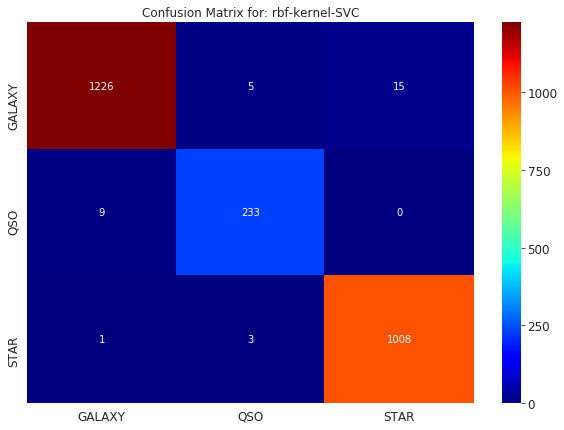

In [6]:
best_indiv = SVC(kernel="rbf", 
                 C=18329.8071083243,
                 gamma=0.004281332398719387, 
                 degree=8,
                 coef0=0.0007847599703514606, 
                 shrinking=True,
                 probability=True,
                 tol=0.001,
                 cache_size=100, 
                 class_weight=None,
                 verbose=False, 
                 max_iter=-1, 
                 random_state=42)

clf_names = ["rbf-kernel-SVC"]
class_names = ["GALAXY", "QSO", "STAR"]

clfs = [best_indiv]
data_sets = []
std_scaled_set = DataSet("Standard Scaled", X_train, y_train, X_test, y_test)
data_sets.append(std_scaled_set)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)